In [1]:
# Importing necessary libraries
import io
import json
import glob
import ast
import re
import string
import requests
from PIL import Image


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Tokenize texts into bigrams and count frequencies
import nltk
from nltk.util import bigrams
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder


import joblib


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')




class DataSourcing:
    def __init__(self):
        self.df = None

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
    def dataframe_details(self,df):
        """
        Print details of the dataframe.
        Parameters:
        df (DataFrame): The dataframe to be analyzed.
        Returns:
        None
        """
        print("============================")
        print(f"DATAFRAME SHAPE: {df.shape}")
        print("============================\n\n")
        print("================")
        print(f"DATAFRAME HEAD:")
        print("================")
        print(f"{df.head()}")
        print("========================================================================\n\n")
        print("=======================")
        print(f"DATAFRAME COLUMNS INFO:")
        print("=======================")
        print(f"{df.info()}")
        print("========================================================================\n\n")
        print("==========================")
        print(f"DATAFRAME KEY STATISTICS:")
        print("==========================")
        print(f"{df.describe().transpose()}")
        print("========================================================================\n\n")

class DataPreprocessing(DataSourcing):
    def __init__(self):
        super().__init__()

    def check_duplicates(self, data):
        duplicates = data[data.duplicated()].shape[0]
        print("There are {} duplicates in the data.".format(duplicates))


    def check_null_values(self, data):
        null_values = data.isnull().sum()
        print(null_values)
        print("====================================")
        print("List of columns with missing values:")
        print("====================================")
        return null_values[null_values > 0].index.tolist()
    
    # 1. Extract reviews and texts from reviewTags
    def extract_reviews_and_texts(self, data):
        data['reviewTags'] = data['reviewTags'].apply(ast.literal_eval)
        data['texts'] = data['reviewTags'].apply(lambda x: [d['text'] for d in x])
        data['reviews'] = data['reviewTags'].apply(lambda x: [d['reviews'] for d in x])
        return data[['reviewTags', 'texts', 'reviews']].head()
        
    # 2. Decode the priceLevel column
    def decode_price_level(self, data):
        def map_dollar_signs(dollar_signs):
            mapping = {
                "$$$$": "Luxury",
                "$$$": "Premium",
                "$$": "Standard",
                "$": "Budget"
            }
            return mapping.get(dollar_signs, "Unknown")
        
        data['priceLevel'] = data['priceLevel'].apply(map_dollar_signs)
        
    
    # 3. Create new price columns (upperPrice & lowerPrice)
    def create_price_columns(self, data, conversion_rate=145.0):
        def convert_and_extract(x):
            if isinstance(x, str):
                if '$' in x:
                    lower_price = float(x.split(' - ')[0].replace('$', '').replace(',', '')) * conversion_rate
                    upper_price = float(x.split(' - ')[-1].replace('$', '').replace(',', '')) * conversion_rate
                elif 'KES' in x:
                    lower_price = float(x.split(' - ')[0].replace('KES', '').replace(',', ''))
                    upper_price = float(x.split(' - ')[-1].replace('KES', '').replace(',', ''))
                return lower_price, upper_price
            return np.nan, np.nan

        data[['lowerPrice', 'upperPrice']] = data['priceRange'].apply(
            lambda x: pd.Series(convert_and_extract(x))
        )
      
    
    # 4. Create new column (weighted_sentiment) for Sentiment Analysis of Reviews
    def create_sentiment_columns(self, data):
        def calculate_weighted_sentiment(texts, reviews):
            sentiments = [TextBlob(text).sentiment.polarity for text in texts]
            weighted_sentiments = [sentiment * review for sentiment, review in zip(sentiments, reviews)]
            total_reviews = sum(reviews)
            weighted_average_sentiment = sum(weighted_sentiments) / total_reviews if total_reviews > 0 else 0
            return weighted_average_sentiment

        def bayesian_average(sentiment, num_reviews, C=10, m=0.03):
            return (C * m + sentiment * num_reviews) / (C + num_reviews)

        data['weighted_sentiment'] = data.apply(lambda row: calculate_weighted_sentiment(row['texts'], row['reviews']), axis=1)
        data['adjusted_sentiment'] = data.apply(
            lambda row: bayesian_average(
                row['weighted_sentiment'], 
                row['numberOfReviews'], 
                C=10, 
                m=data['weighted_sentiment'].mean()
            ), 
            axis=1
        )
      
    
    # 5. Extract the location & province from locationString
    def extract_location_and_province(self, data):
        data['locationString'] = data['locationString'].apply(lambda x: np.nan if pd.isnull(x) or x.strip() == '' else x)
        data['location'] = data['locationString'].str.split(',', n=1).str[0].str.strip()
        data['province'] = data['locationString'].str.split(',').str[-1].str.strip()
        return data[['location', 'province']].head()
    
    # 6. Create a new value tour operator in the category column
    def update_category_column(self, data):
        keywords = ['safari', 'safaris', 'tour', 'tours', 'adventure',
                    'adventures', 'expeditions', 'expedition', 'travels',
                    'travel', 'travellers', 'escursioni']
        hotel_keywords = ['cottages', 'spa', 'lodge', 'camp', 'club', 'hotel', 'resort']

        def update_category(row):
            name, current_category = row
            name_lower = name.lower()

            if any(hotel_keyword in name_lower for hotel_keyword in hotel_keywords):
                return 'hotel'
            
            if any(keyword in name_lower for keyword in keywords):
                return 'tour operator'
            
            return current_category

        data['category'] = data[['name', 'category']].apply(update_category, axis=1)
        return data['category'].value_counts()
    
    def label_encode_columns(self, data, columns):
        """
        Label encode specified columns in the dataframe.
        
        Parameters:
        - data: DataFrame containing the columns to be encoded.
        - columns: List of column names to be label encoded.

        Returns:
        - data: DataFrame with the specified columns label encoded.
        """
        label_encoder = LabelEncoder()
        for column in columns:
            data[column + '_encoded'] = label_encoder.fit_transform(data[column])


class DataAnalysis(DataPreprocessing, DataSourcing):

    def __init__(self):
        super().__init__()

    # 1. Visual of the Destinations
    def visualize_destinations(self, data):
        image_urls = data['image'].tolist()
        images = []

        for url in image_urls[0:9]:
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    img = Image.open(io.BytesIO(response.content))
                    images.append(img)
                else:
                    images.append(None)
            except Exception as e:
                print(f"Error fetching image from {url}: {e}")
                images.append(None)

        num_rows, num_cols = 3, 3
        image_matrix = [[None for _ in range(num_cols)] for _ in range(num_rows)]

        for idx, img in enumerate(images):
            row, col = divmod(idx, num_cols)
            if row < num_rows:
                image_matrix[row][col] = img

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
        for i in range(num_rows):
            for j in range(num_cols):
                if image_matrix[i][j] is not None:
                    axs[i, j].imshow(image_matrix[i][j])
                    axs[i, j].set_title(data.loc[i * num_cols + j, 'name'])
                axs[i, j].axis('off')

        plt.tight_layout()
        plt.show()

    # 2. Bigrams Visual
    def visualize_bigrams(self, data):
        def get_bigrams(texts, reviews):
            bigram_counts = Counter()
            for text, review in zip(texts, reviews):
                tokens = nltk.word_tokenize(text)
                bigrams_list = list(bigrams(tokens))
                for bigram in bigrams_list:
                    bigram_counts[bigram] += review
            return bigram_counts

        data['bigram_counts'] = data.apply(lambda row: get_bigrams(row['texts'], row['reviews']), axis=1)

        def flatten_bigrams(bigram_counts):
            flattened_text = []
            for bigram, count in bigram_counts.items():
                flattened_text.extend([' '.join(bigram)] * count)
            return ' '.join(flattened_text)

        data['flattened_bigrams'] = data['bigram_counts'].apply(flatten_bigrams)

        total_bigram_counts = Counter()
        for counts in data['bigram_counts']:
            total_bigram_counts.update(counts)

        most_common_bigrams = total_bigram_counts.most_common(10)
        bigram_labels, bigram_values = zip(*most_common_bigrams)

        bigram_labels = [' '.join(bigram) for bigram in bigram_labels]
        plot_data = pd.DataFrame({'Bigram': bigram_labels, 'Count': bigram_values})

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Count', y='Bigram', data=plot_data, palette='magma')
        plt.xlabel('Weighted Review Count')
        plt.ylabel('Bigrams')
        plt.title('Top 10 Bigrams by Review Count')
        plt.show()

    # 3. Most Frequently Used Words in Reviews
    def frequent_words_in_reviews(self, data):
        combined_texts = ' '.join(' '.join(texts) for texts in data['texts'])

        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(combined_texts)

        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Most Frequent Words in Reviews')
        plt.show()

        def preprocess(text):
            words = text.lower().split()
            words = [word for word in words if word.isalpha() and len(word) > 2]
            return words

        words = preprocess(combined_texts)
        word_counts = Counter(words)

        print("20 most common words:")
        for word, count in word_counts.most_common(20):
            print(f"{word}: {count}")

    # 4. Most Common Review Tags for Highly-Rated Attractions
    def common_review_tags(self, data):
        high_rated = data[data['rating'] >= 4.5]

        def extract_tags(tags_list):
            return [tag['text'] for tag in tags_list]

        all_tags = [tag for tags in high_rated['reviewTags'] for tag in extract_tags(tags)]
        top_tags = Counter(all_tags).most_common(10)

        plt.figure(figsize=(12, 6))
        sns.barplot(y=[tag[0] for tag in top_tags], x=[tag[1] for tag in top_tags], palette='magma')
        plt.title('Top 10 Review Tags for Highly-Rated Attractions (by Rating)')
        plt.xlabel('Count')
        plt.ylabel('Tags')
        plt.tight_layout()
        plt.show()

    # 5. Most Frequently Used Words by Category
    def frequent_words_by_category(self, data):
        for category in data['category'].unique():
            category_texts = ' '.join(' '.join(texts) for texts, cat in zip(data['texts'], data['category']) if cat == category)

            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(category_texts)

            plt.figure(figsize=(12, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud for Category: {category}')
            plt.show()

    # 6. Univariate Analysis
    def plot_distribution(self, data, exclude_columns=[]):
        for col in data.columns:
            if col in exclude_columns:
                continue

            if data[col].dtype == 'object' or data[col].nunique() < 20:
                sns.countplot(data=data, x=col, palette='magma')
                plt.title(f"Distribution of '{col}'")
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.show()
            elif pd.api.types.is_numeric_dtype(data[col]):
                sns.histplot(data[col], kde=True, stat="density", palette='magma')
                plt.title(f"Distribution of '{col}'")
                plt.xlabel(col)
                plt.ylabel('Density')
                plt.show()

    # 7. Correlation Analysis
    def correlation(self, data, column=None, rank=None):
        df_object = data.select_dtypes(include='object')
        print(f'The following columns were dropped due to being object types:\n{df_object.columns.tolist()}')
        data = data.drop(df_object, axis=1)
        
        if rank:
            df_corr = data.corr()[column] if column else data.corr()
            df_corr = df_corr.drop(column) if column else df_corr
            return df_corr.sort_values(by=column, ascending=False) if column else df_corr.sort_values(ascending=False)
    # 8. Correlation Matrix
    def correlation_matrix(self, data, numerical_columns):
        corr_matrix = data[numerical_columns].corr()

        plt.figure(figsize=(16, 16))
        mask = np.zeros_like(corr_matrix, dtype=bool)
        mask[np.triu_indices_from(mask)] = True

        sns.heatmap(corr_matrix, mask=mask, cmap='magma', center=0, annot=True)
        plt.title('Correlation Matrix of Numerical Features', fontsize=20)
        plt.show()

    # 9. Price Range Variation by Price Level
    def price_range_variation(self, data):
        price_level_range = data.groupby('priceLevel').agg({
            'lowerPrice': 'mean',
            'upperPrice': 'mean'
        })

        fig, ax = plt.subplots(figsize=(10, 6))
        bar_width = 0.35
        r1 = np.arange(len(price_level_range))
        r2 = [x + bar_width for x in r1]

        ax.bar(r1, price_level_range['lowerPrice'], color='b', width=bar_width, edgecolor='grey', label='Lower Price')
        ax.bar(r2, price_level_range['upperPrice'], color='r', width=bar_width, edgecolor='grey', label='Upper Price')

        ax.set_xlabel('Price Level', fontweight='bold')
        ax.set_ylabel('Price', fontweight='bold')
        ax.set_title('Average Lower and Upper Prices by Price Level', fontweight='bold')
        ax.set_xticks([r + bar_width / 2 for r in range(len(price_level_range))])
        ax.set_xticklabels(price_level_range.index)

        ax.legend()
        plt.show()


    def analyze_photo_rating_reviews_corr(self, data):
        """
        Analyze the correlation between the number of photos and rating or number of reviews.
        Generates scatter plots with regression lines.
        """
        # Calculate correlations
        photo_rating_corr = data['photoCount'].corr(data['rating'])
        photo_reviews_corr = data['photoCount'].corr(data['numberOfReviews'])

        print(f"Correlation between photo count and rating: {photo_rating_corr:.2f}")
        print(f"Correlation between photo count and number of reviews: {photo_reviews_corr:.2f}")

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Scatter plot with regression line for photo count vs rating
        sns.regplot(x='photoCount', y='rating', data=data, ax=axes[0], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[0].set_title(f'Photo Count vs Rating\nCorrelation: {photo_rating_corr:.2f}')
        axes[0].set_xlabel('Photo Count')
        axes[0].set_ylabel('Rating')

        # Scatter plot with regression line for photo count vs number of reviews
        sns.regplot(x='photoCount', y='numberOfReviews', data=data, ax=axes[1], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[1].set_title(f'Photo Count vs Number of Reviews\nCorrelation: {photo_reviews_corr:.2f}')
        axes[1].set_xlabel('Photo Count')
        axes[1].set_ylabel('Number of Reviews')

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

    def analyze_province_distribution(self, data):
        """
        Analyze the distribution of listings across different provinces.
        Generates a bar plot showing the distribution.
        """
        plt.figure(figsize=(14, 7))
        sns.countplot(y='province', data=data, order=data['province'].value_counts().index, palette='magma')
        plt.title('Distribution of Provinces', fontsize=16)
        plt.xlabel('Count')
        plt.ylabel('Province')
        plt.show()

    def analyze_sentiment_by_province(self, province_aggregates):
        """
        Analyze how average sentiment varies across different provinces.
        Generates a scatter plot showing average sentiment by province.
        """
        plt.figure(figsize=(14, 7))
        sns.scatterplot(y='Province', x='Average Weighted Sentiment', data=province_aggregates, size='Total Reviews', sizes=(50, 500), hue='Average Rating', palette='coolwarm', legend=False)
        plt.title('Average Sentiment by Province', fontsize=16)
        plt.xlabel('Average Weighted Sentiment')
        plt.ylabel('Province')
        plt.show()

    def analyze_ratings_reviews_by_category(self, data):
        """
        Analyze how average ratings and total number of reviews vary across different categories.
        Generates bar plots showing the mean rating and total number of reviews by category.
        """
        category_analysis = data.groupby('category').agg({
            'rating': 'mean',
            'numberOfReviews': 'sum'
        }).reset_index()

        category_analysis_sorted_by_rating = category_analysis.sort_values(by='rating', ascending=False)
        category_analysis_sorted_by_reviews = category_analysis.sort_values(by='numberOfReviews', ascending=False)

        plt.figure(figsize=(14, 8))
        sns.set(style="whitegrid")

        # Plot for mean rating by category
        plt.subplot(2, 1, 1)
        sns.barplot(x='rating', y='category', data=category_analysis_sorted_by_rating, palette='viridis')
        plt.title('Mean Rating by Category')
        plt.xlabel('Mean Rating')
        plt.ylabel('Category')

        # Plot for total number of reviews by category
        plt.subplot(2, 1, 2)
        sns.barplot(x='numberOfReviews', y='category', data=category_analysis_sorted_by_reviews, palette='magma')
        plt.title('Total Number of Reviews by Category')
        plt.xlabel('Total Number of Reviews')
        plt.ylabel('Category')

        plt.tight_layout()
        plt.show()

    def analyze_avg_price_by_category(self, data):
        """
        Analyze the average price range for different categories.
        Generates a bar plot showing the average price by category.
        """
        avg_price_by_category = data.groupby('category')['averagePrice'].mean().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        avg_price_by_category.plot(kind='bar')
        plt.title('Average Price by Category')
        plt.xticks()
        plt.tight_layout()
        plt.show()

In [2]:
ds = DataSourcing()

files = [
        "data\kenya.json", "data\Tripadvisor1.json",
        "data\Tripadvisor2.json", "data\Tripadvisor3.json", "data\Tripadvisor4.json"
        ]
expected_columns = [
        "name", "category", "rating", "numberOfReviews",
        "image", "photoCount", "priceRange", "reviewTags",
        "priceLevel", "locationString"
                    ]

data = ds.read_json_files(files, expected_columns)

In [3]:
ds.dataframe_details(data)

DATAFRAME SHAPE: (5544, 10)


DATAFRAME HEAD:
                                      name    category  rating  \
0                         Observation Hill  attraction     4.5   
1             Mount Longonot National Park  attraction     4.5   
2  Karen Blixen Coffee Garden and Cottages  attraction     4.5   
3                           Kiambethu Farm  attraction     5.0   
4                        Fort Jesus Museum  attraction     4.0   

   numberOfReviews                                              image  \
0              782  https://media-cdn.tripadvisor.com/media/photo-...   
1              208  https://media-cdn.tripadvisor.com/media/photo-...   
2              591  https://media-cdn.tripadvisor.com/media/photo-...   
3              226  https://media-cdn.tripadvisor.com/media/photo-...   
4              978  https://media-cdn.tripadvisor.com/media/photo-...   

   photoCount priceRange                                         reviewTags  \
0         423        NaN  [{'text': 'gr

In [4]:
# Initialize the data preprocessing class
dp = DataPreprocessing()

# Convert list columns to strings to avoid unhashable type errors
data['reviewTags'] = data['reviewTags'].apply(lambda x: str(x) if isinstance(x, list) else x)

# Check for duplicates
dp.check_duplicates(data)

There are 784 duplicates in the data.


In [5]:
# Drop the duplicate rows
data = data.drop_duplicates()
data.drop_duplicates(subset=['name'], inplace=True)

# Check for duplicates
dp.check_duplicates(data)

There are 0 duplicates in the data.


In [6]:
# Initialize the data preprocessing class
dp = DataPreprocessing()

dp.extract_reviews_and_texts(data)

reviewTags  \
0  [{'text': 'great view', 'reviews': 55}, {'text...   
1  [{'text': 'crater rim', 'reviews': 18}, {'text...   
2  [{'text': 'movie', 'reviews': 42}, {'text': 'a...   
3  [{'text': 'indigenous forest', 'reviews': 22},...   
4  [{'text': 'old town', 'reviews': 132}, {'text'...   

                                               texts  \
0  [great view, vantage point, entire park, short...   
1  [crater rim, day trip, start early, amazing vi...   
2                  [movie, africa, giraffes, safari]   
3  [indigenous forest, tea plantation, delicious ...   
4  [old town, interesting history, slave trade, t...   

                                             reviews  
0  [55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ...  
1  [18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ...  
2                                   [42, 94, 10, 14]  
3  [22, 27, 16, 14, 6, 6, 5, 4, 4, 3, 3, 5, 64, 2...  
4  [132, 17, 17, 46, 28, 9, 14, 14, 121, 28, 36, ...

In [7]:
dp.decode_price_level(data)

# Display the Unique values and their counts
data['priceLevel'].value_counts()

Unknown     896
Budget      443
Standard    292
Luxury      213
Premium     118
Name: priceLevel, dtype: int64

In [8]:
dp.create_price_columns(data)

print(data[['upperPrice', 'lowerPrice']].nunique())
data[['upperPrice', 'lowerPrice']].value_counts().head()

upperPrice    564
lowerPrice    511
dtype: int64


upperPrice  lowerPrice
28129.0     28129.0       3
15190.0     11392.0       3
4282.0      3893.0        2
5191.0      4672.0        2
10549.0     7736.0        2
dtype: int64

In [9]:
dp.create_sentiment_columns(data)

# Display the updated DataFrame
review_data = data[['name','texts','reviews', 'numberOfReviews', 'weighted_sentiment', 'adjusted_sentiment']]

review_data.head()

<class 'pandas.core.series.Series'>
Int64Index: 1962 entries, 0 to 4543
Series name: reviews
Non-Null Count  Dtype 
--------------  ----- 
1962 non-null   object
dtypes: object(1)
memory usage: 30.7+ KB
None


In [10]:
dp.extract_location_and_province(data)

location              province
0  Amboseli National Park  Rift Valley Province
1              Maai Mahiu  Rift Valley Province
2                 Nairobi               Nairobi
3                  Limuru      Central Province
4                 Mombasa        Coast Province

In [11]:
# Display the original DataFrame
print('Original category column:')
print(data['category'].value_counts())

# Updated DataFrame
print('\n\nUpdated category column:')
dp.update_category_column(data)

Original category column:
hotel         1399
attraction     563
Name: category, dtype: int64


Updated category column:


hotel            1404
tour operator     391
attraction        167
Name: category, dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 4543
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                1962 non-null   object 
 1   category            1962 non-null   object 
 2   rating              1959 non-null   float64
 3   numberOfReviews     1962 non-null   int64  
 4   image               1959 non-null   object 
 5   photoCount          1962 non-null   int64  
 6   priceRange          1066 non-null   object 
 7   reviewTags          1962 non-null   object 
 8   priceLevel          1962 non-null   object 
 9   locationString      1445 non-null   object 
 10  texts               1962 non-null   object 
 11  reviews             1962 non-null   object 
 12  lowerPrice          1066 non-null   float64
 13  upperPrice          1066 non-null   float64
 14  weighted_sentiment  1962 non-null   float64
 15  adjusted_sentiment  1962 non-null   float64
 16  locati

In [13]:
eda = DataAnalysis()

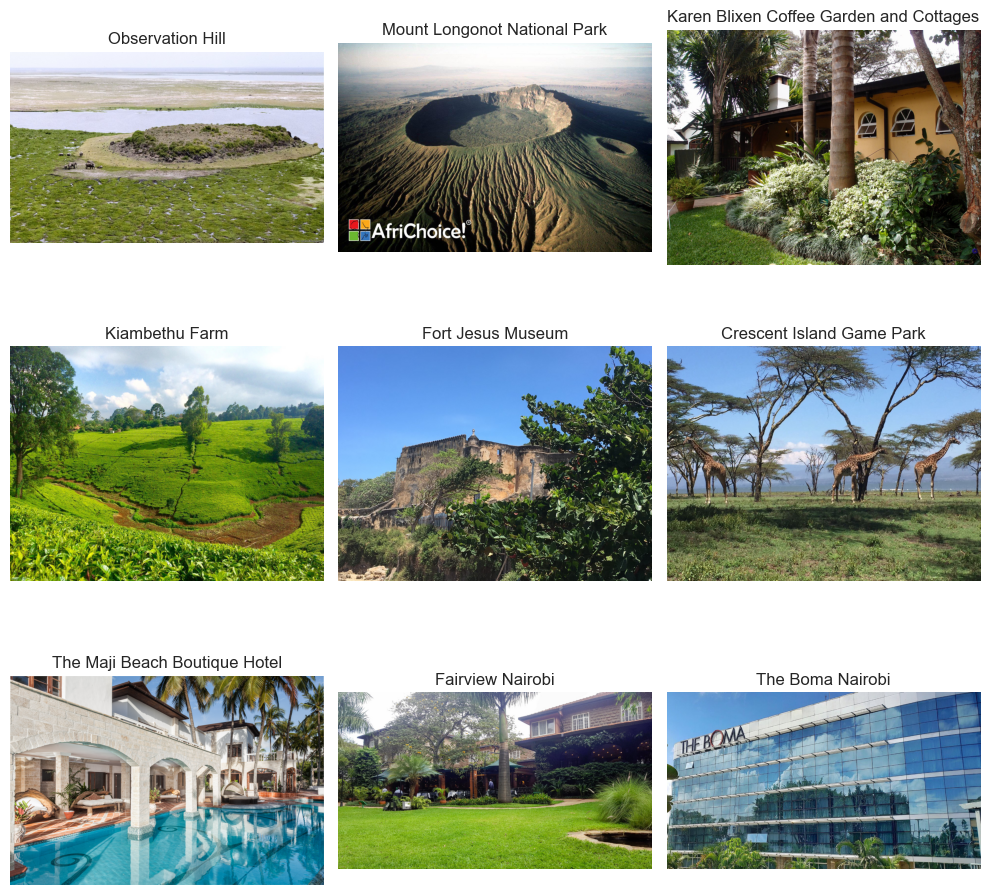

In [14]:
eda.visualize_destinations(data)

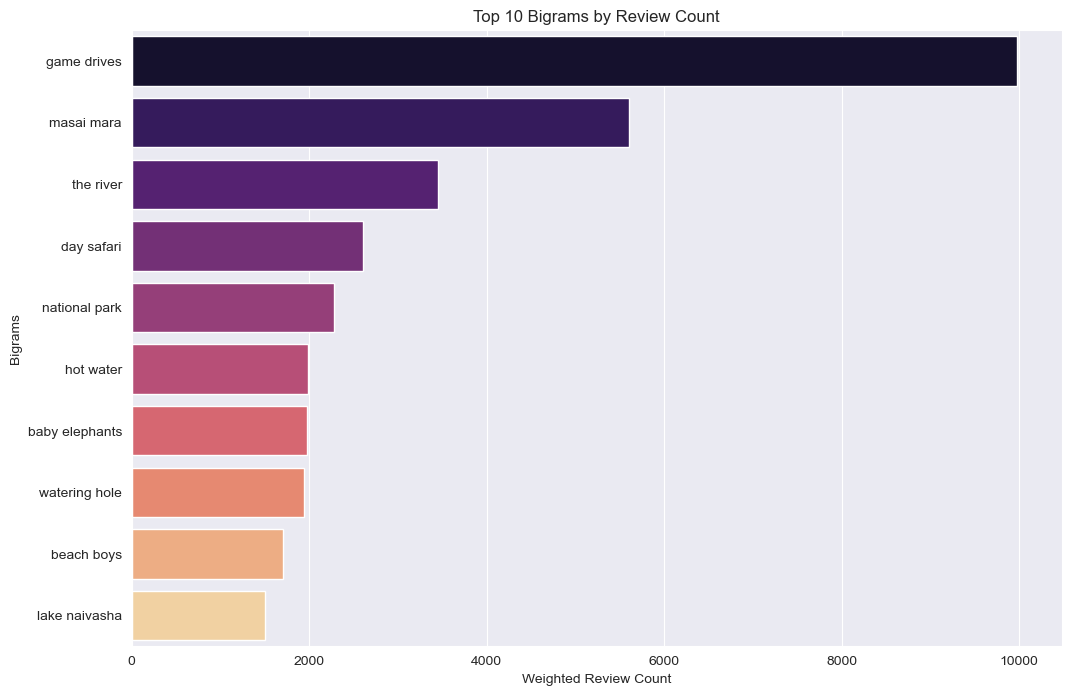

In [15]:
eda.visualize_bigrams(data)

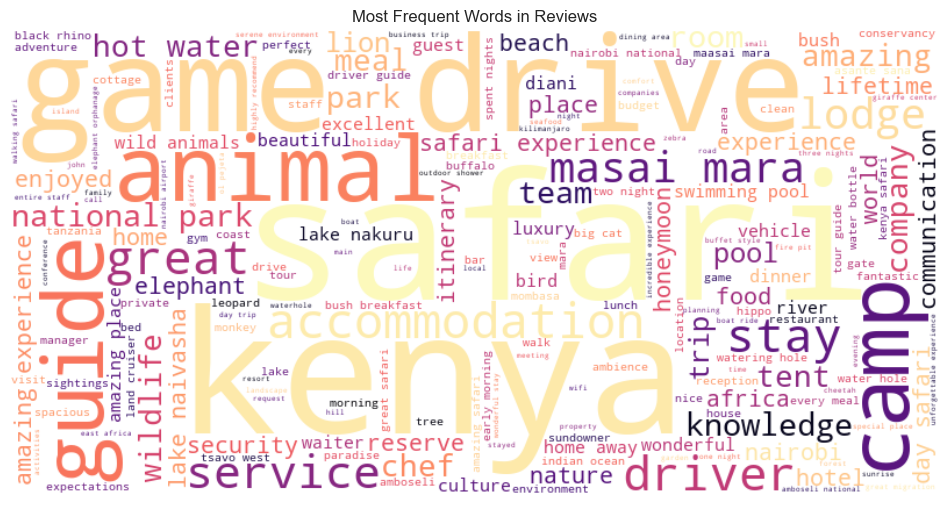

20 most common words:
safari: 846
the: 485
experience: 477
kenya: 473
game: 432
amazing: 385
guide: 379
mara: 354
animals: 349
great: 341
drives: 301
driver: 299
camp: 292
stay: 285
water: 266
place: 241
park: 237
trip: 233
pool: 226
masai: 223


In [16]:
eda.frequent_words_in_reviews(data)

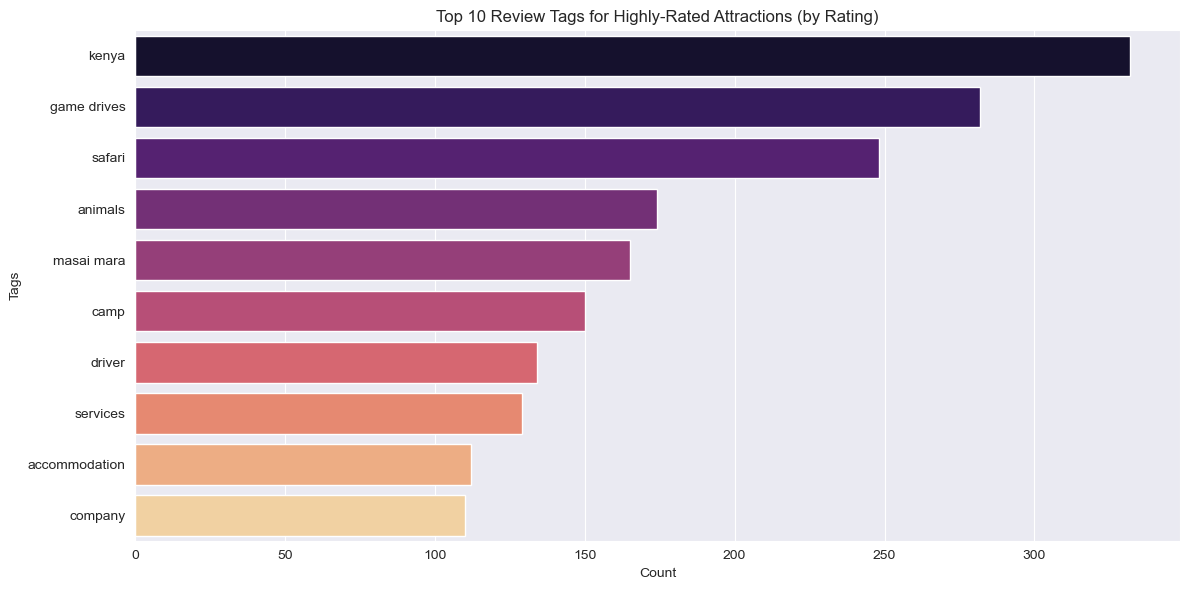

In [17]:
eda.common_review_tags(data)

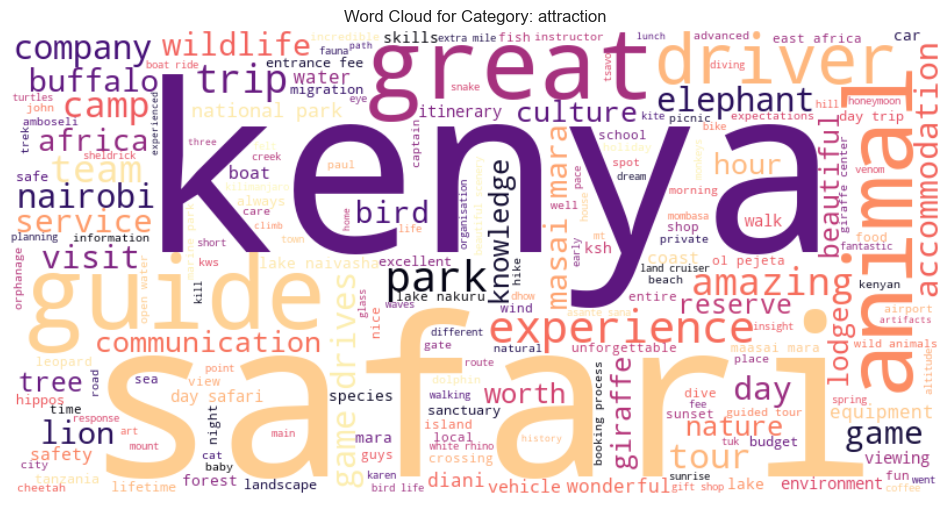

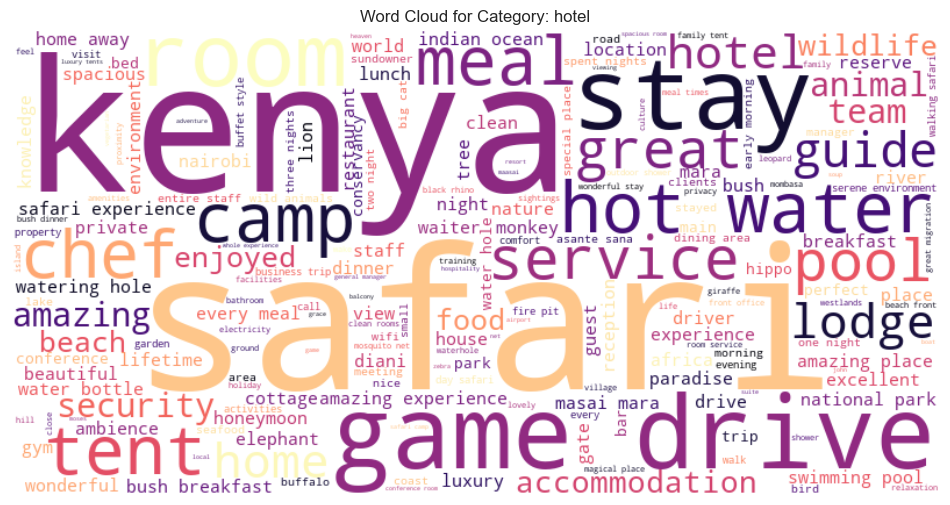

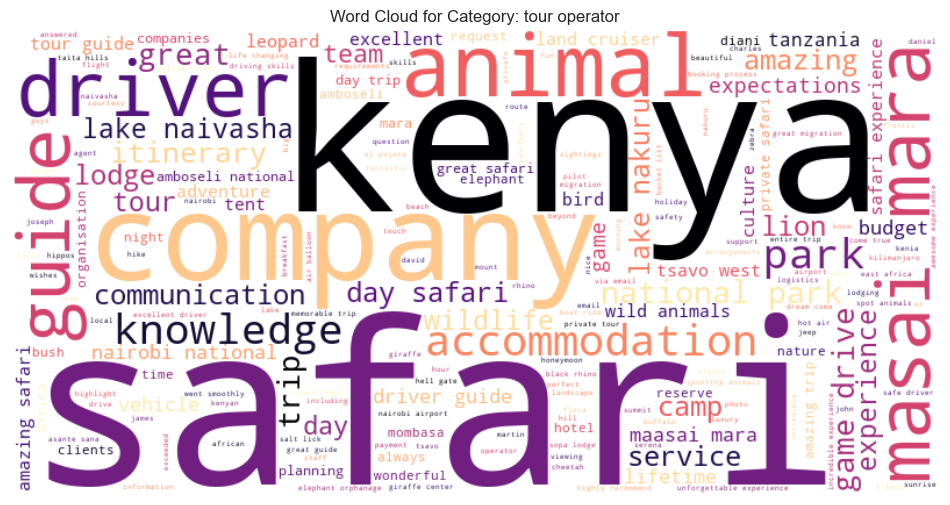

In [18]:
eda.frequent_words_by_category(data)

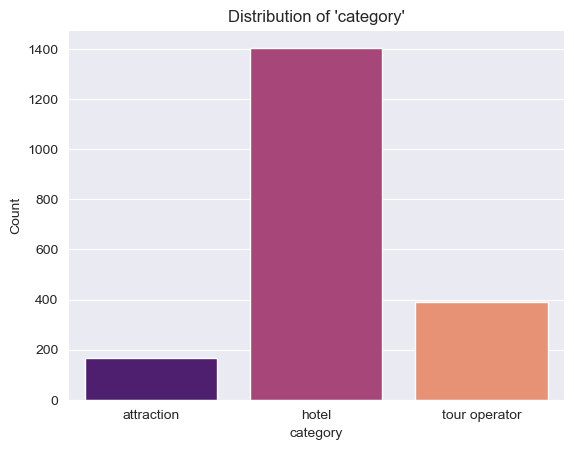

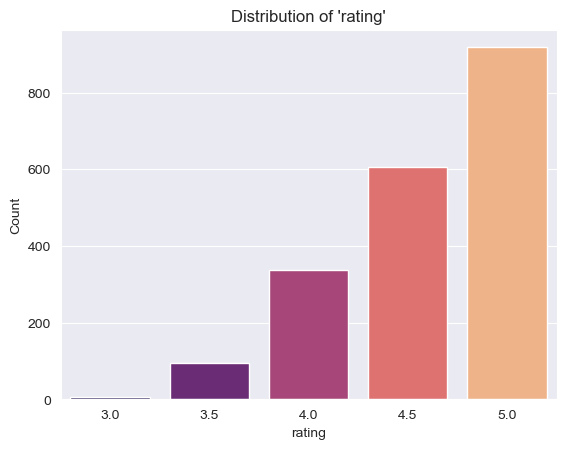

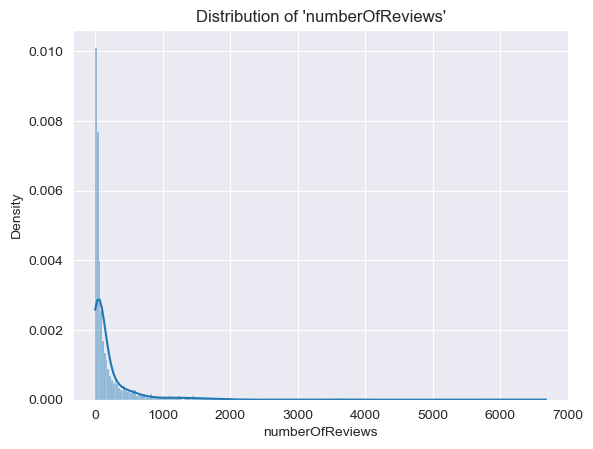

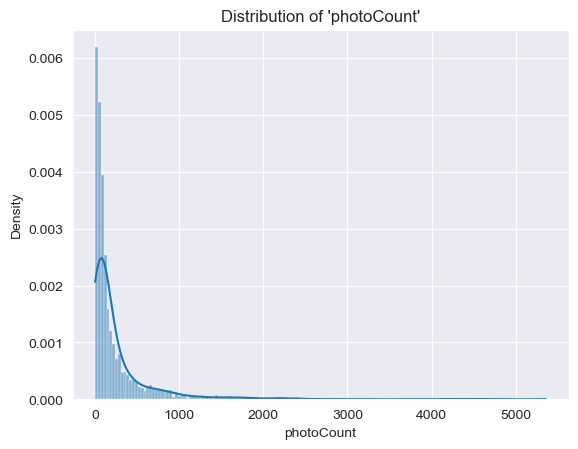

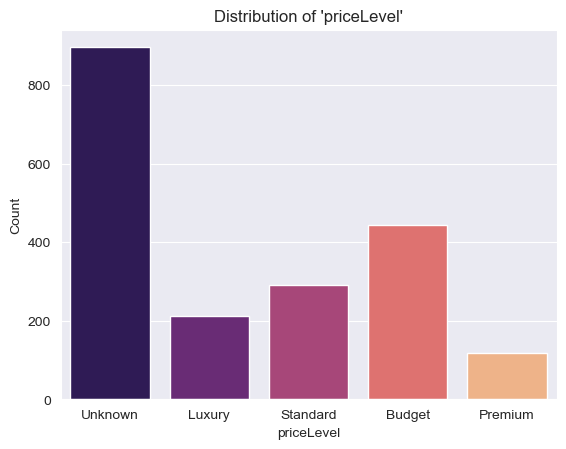

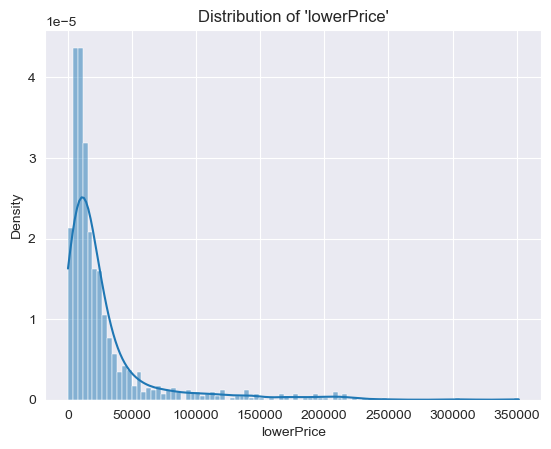

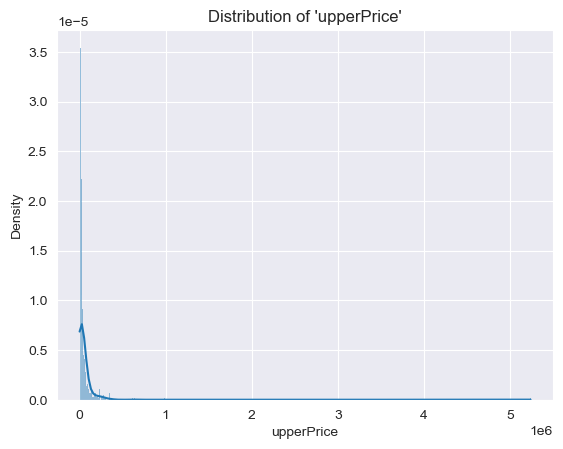

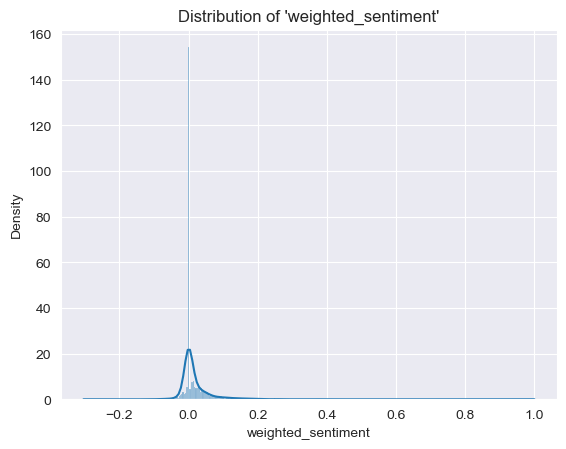

In [19]:
exclude = ['name', 'image', 'priceRange', 'reviewTags', 'photos', 'reviews', 'texts', 'adjusted_sentiment',
           'bigram_counts', 'location', 'province', 'locationString', 'flattened_bigrams']

eda.plot_distribution(data, exclude_columns=exclude)

In [20]:
dp.label_encode_columns(data, ['priceLevel'])

In [21]:
data.columns

Index(['name', 'category', 'rating', 'numberOfReviews', 'image', 'photoCount',
       'priceRange', 'reviewTags', 'priceLevel', 'locationString', 'texts',
       'reviews', 'lowerPrice', 'upperPrice', 'weighted_sentiment',
       'adjusted_sentiment', 'location', 'province', 'bigram_counts',
       'flattened_bigrams', 'priceLevel_encoded'],
      dtype='object')

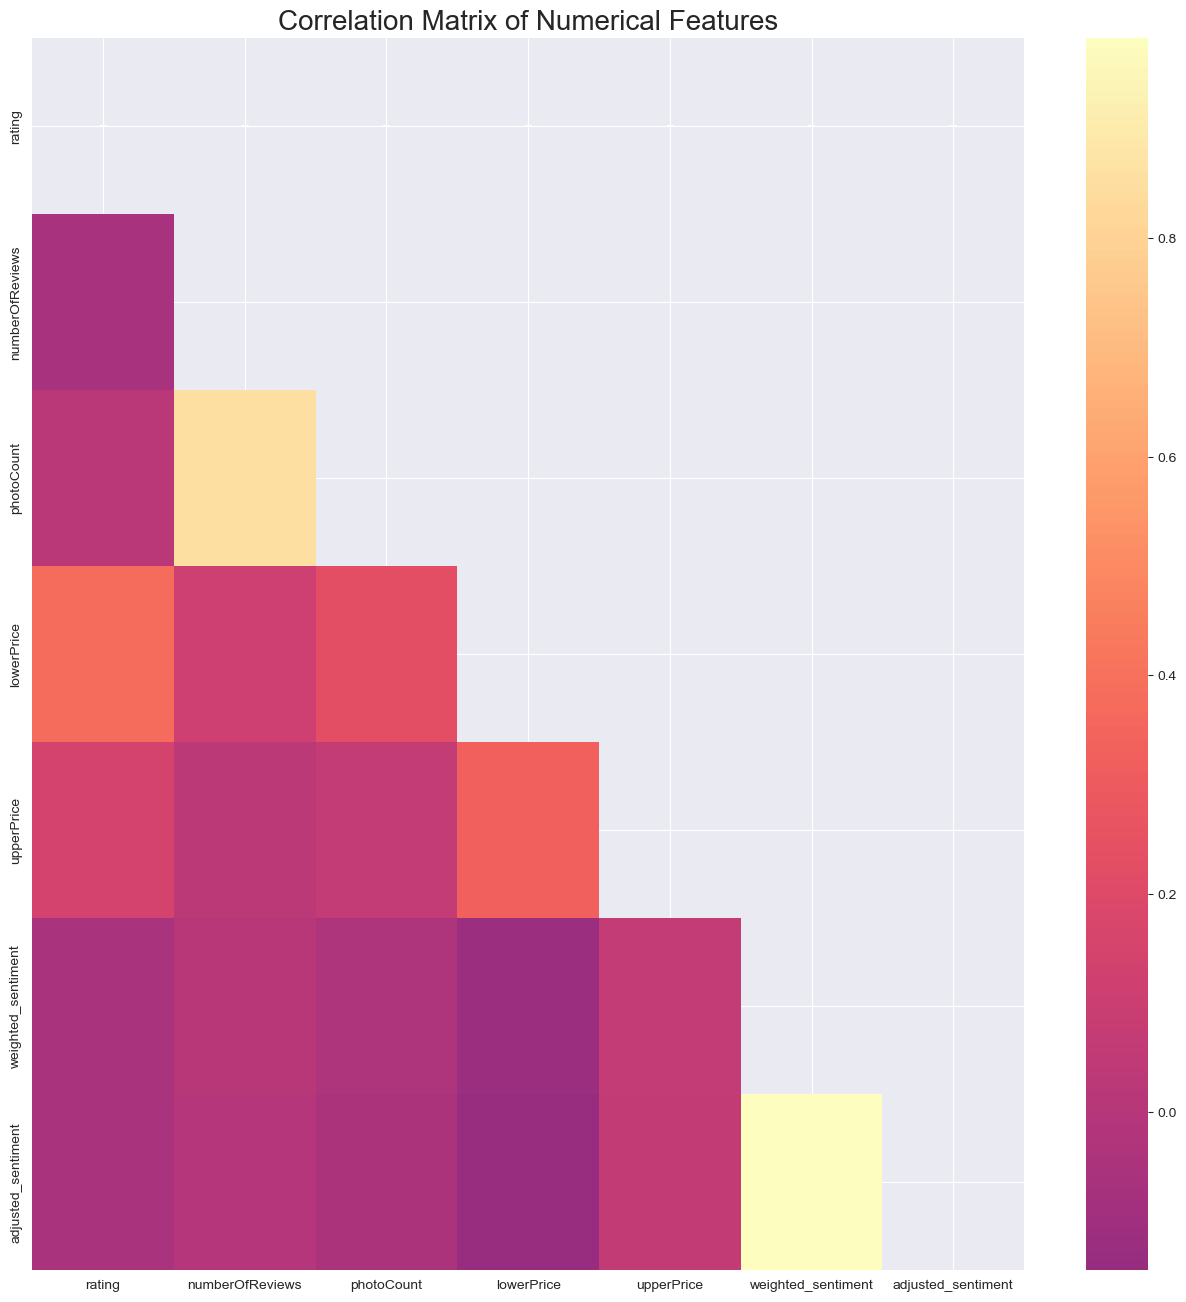

In [22]:
# Create a correlation matrix
numerical_columns = [
    'rating',
    'numberOfReviews',
    'photoCount',
    'lowerPrice',
    'upperPrice',
    'weighted_sentiment',
    'adjusted_sentiment'
]

eda.correlation_matrix(data, numerical_columns)

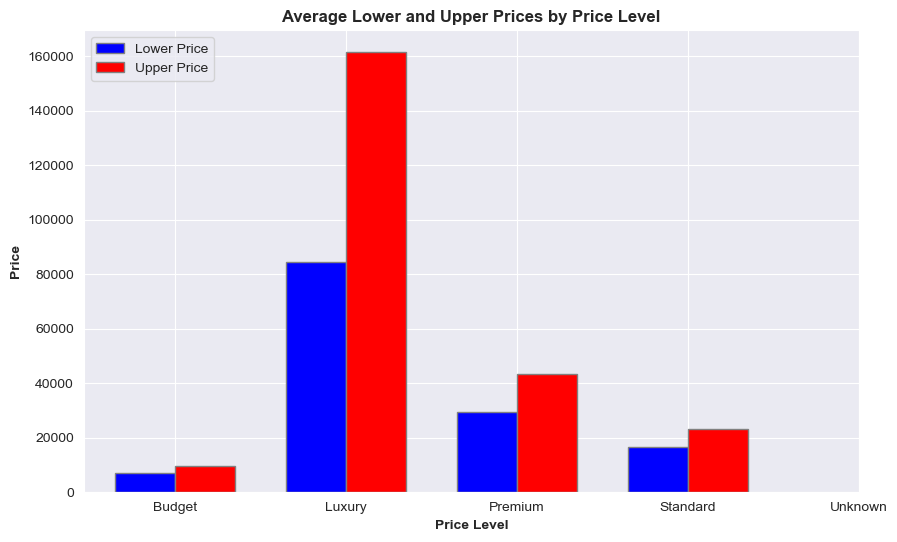

In [23]:
eda.price_range_variation(data)

Correlation between photo count and rating: 0.02
Correlation between photo count and number of reviews: 0.86


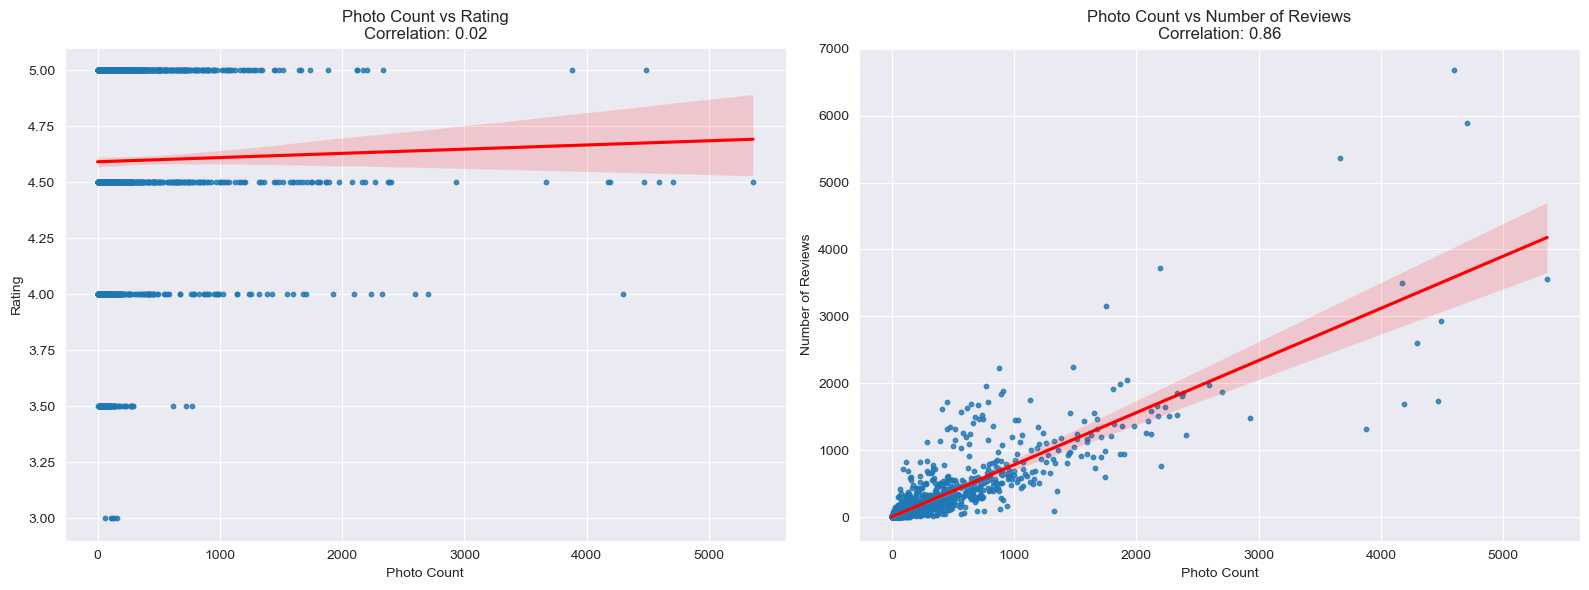

In [24]:
eda.analyze_photo_rating_reviews_corr(data)

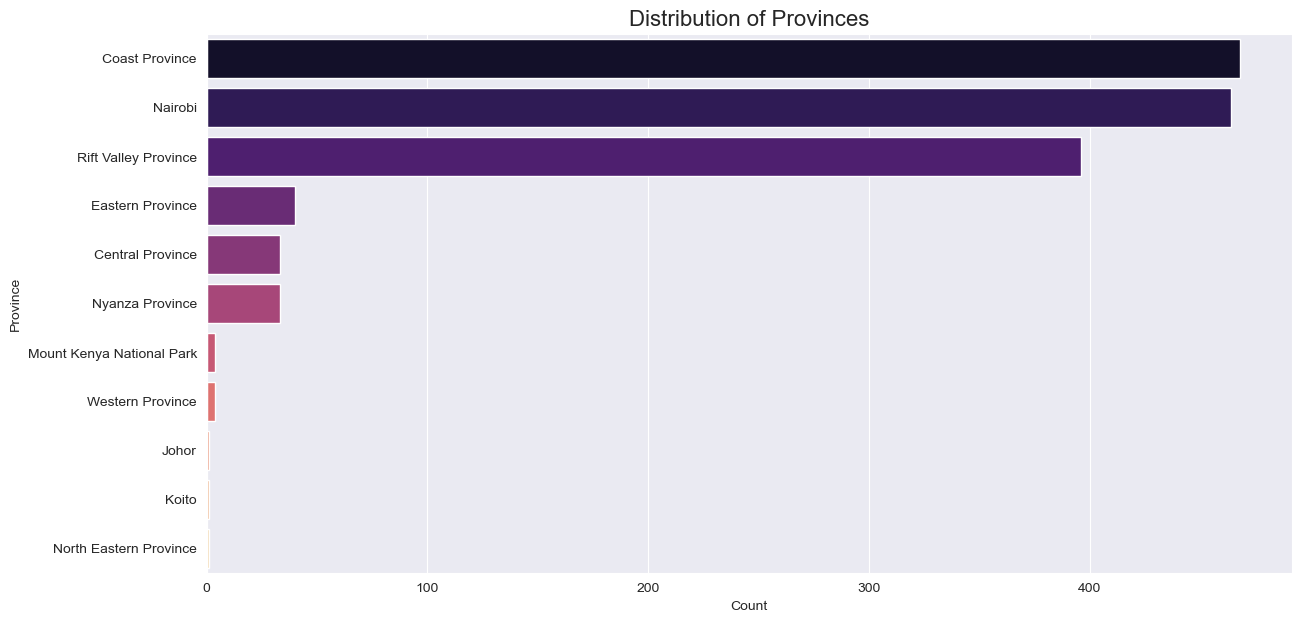

In [25]:
eda.analyze_province_distribution(data)

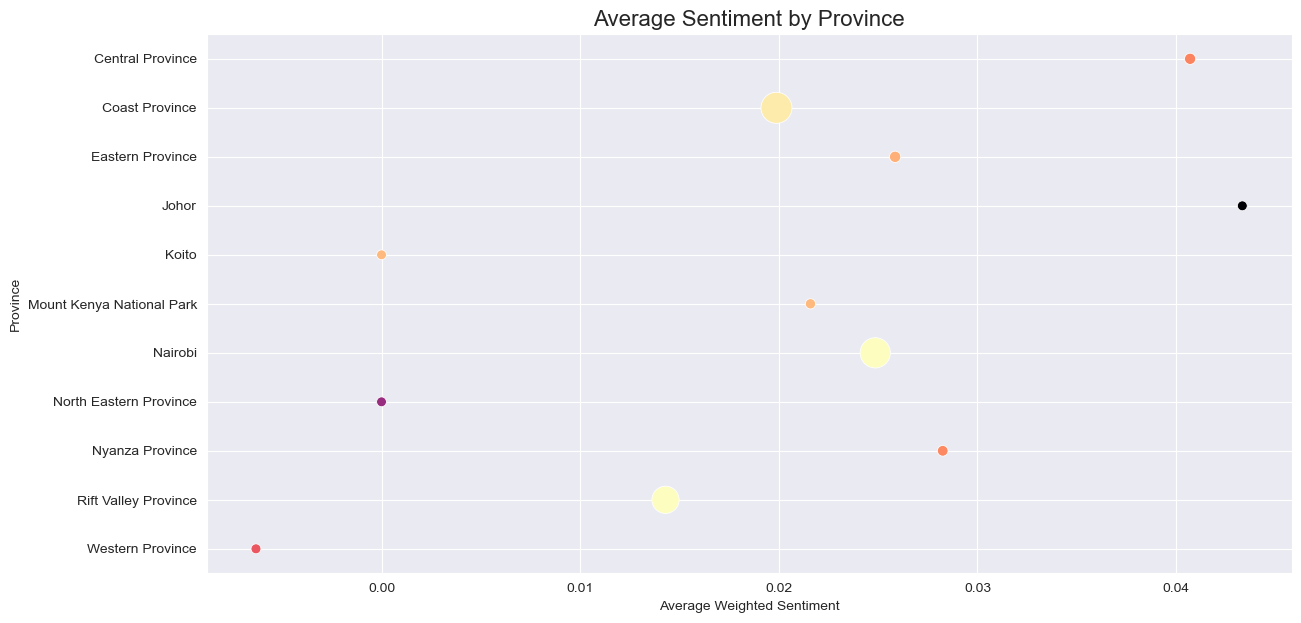

In [26]:
# Aggregate data by province
province_aggregates = data.groupby('province').agg({
    'rating': 'mean',
    'numberOfReviews': 'sum',
    'weighted_sentiment': 'mean',
    'adjusted_sentiment': 'mean'
}).reset_index()

# Rename columns for clarity
province_aggregates.columns = ['Province', 'Average Rating', 'Total Reviews', 'Average Weighted Sentiment', 'Average Adjusted Sentiment']

eda.analyze_sentiment_by_province(province_aggregates)

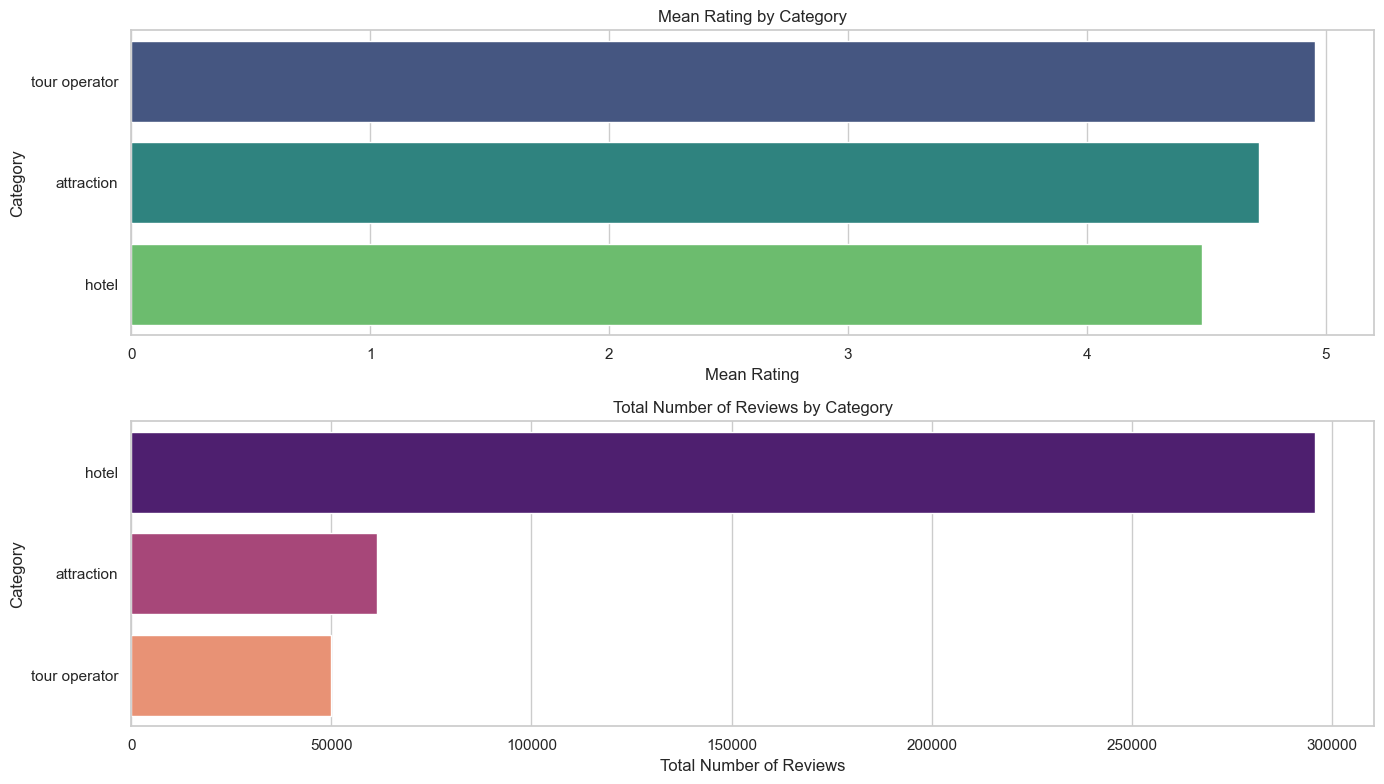

In [27]:
eda.analyze_ratings_reviews_by_category(data)

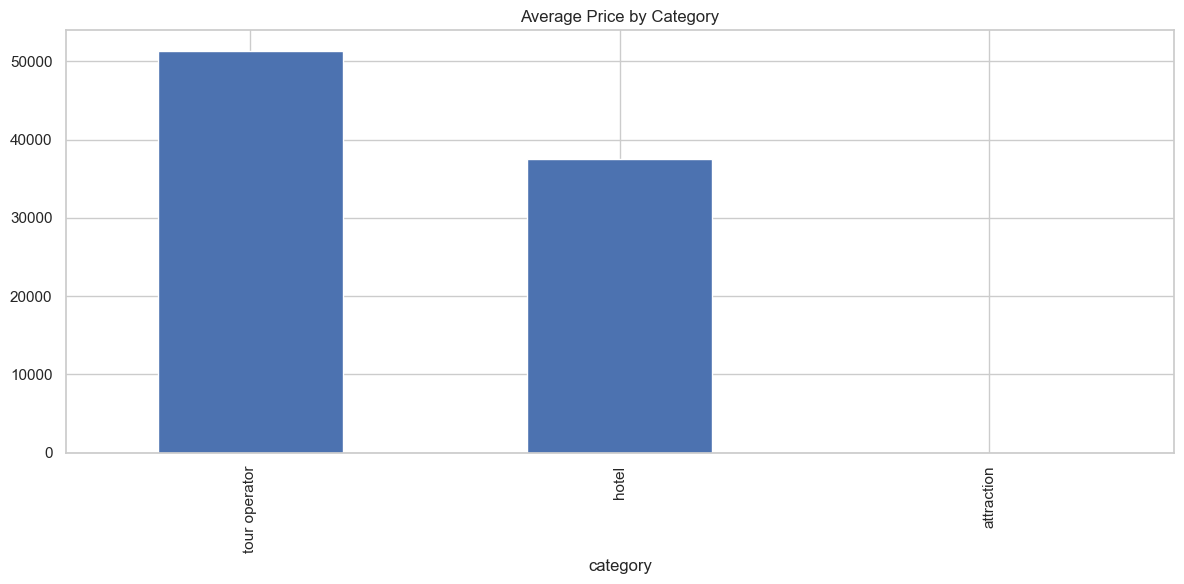

In [28]:
data['averagePrice'] = (data['lowerPrice'] + data['upperPrice']) / 2

eda.analyze_avg_price_by_category(data)